In [ ]:
# !pip install cleantext

In [1]:
# !pip install matplotlib==3.4.0

In [3]:
import pandas as pd
import re, string
# import cleantext
# from cleantext import clean
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
print(matplotlib.__version__)

3.4.0


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 7.6 MB 67.1 MB/s 
     |████████████████████████████████| 182 kB 78.8 MB/s 


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Train, Test and Validation data from SemEval 2017 Task 4

In [10]:
X_train = pd.read_csv('drive/MyDrive/Dataset/GOLD/Subtask_A/twitter-2016train-A.txt', sep='\t+', header=None)
X_train.shape

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(6000, 3)

In [11]:
X_test = pd.read_csv('drive/MyDrive/Dataset/GOLD/Subtask_A/twitter-2016test-A.txt', sep='\t', header=None)
X_test = X_test.drop([3], axis=1)
X_test.shape

(20632, 3)

In [12]:
X_val = pd.read_csv('drive/MyDrive/Dataset/GOLD/Subtask_A/twitter-2016devtest-A.txt', sep='\t', header=None)
X_val.shape

(2000, 3)

In [14]:
X_train[1].value_counts()

positive    3094
neutral     2043
negative     863
Name: 1, dtype: int64

In [15]:
X_train.drop_duplicates(subset=[2], inplace=True)

In [16]:
X_train.reset_index(drop=True, inplace=True)
X_train

,0,1,2
0,628949369883000832,negative,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,negative,@Microsoft how about you make a system that do...
2,629023169169518592,negative,I may be ignorant on this issue but... should ...
3,629179223232479232,negative,"Thanks to @microsoft, I just may be switching ..."
4,629186282179153920,neutral,If I make a game as a #windows10 Universal App...
...,...,...,...
5970,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
5971,639979760735662080,neutral,everyone who sat around me at metlife was so a...
5972,640196838260363269,neutral,what giants or niners fans would wanna go to t...
5973,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [17]:
df_train = X_train[[1, 2]]
df_test = X_test[[1, 2]]
df_val = X_val[[1, 2]]

### Perform Data Cleaning like removing emoji, irrelavant characters, extra spaces

In [18]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    # return re.sub(emoji.emoji_list(), r"", text) #remove emoji
    # rem = clean(text, no_emoji=True)
    # return rem
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [19]:
texts_new = []
for t in df_train[2]:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [20]:
texts_new_test = []
for t in df_test[2]:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [21]:
texts_new_val = []
for t in df_val[2]:
    texts_new_val.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [22]:
df_train['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [23]:
df_val['text_clean'] = texts_new_val

In [24]:
df_train['text_clean'].head()

0    dear the newooffice for mac is great and all b...
1    how about you make a system that doesnt eat my...
2    i may be ignorant on this issue but should we ...
3            thanks to i just may be switching over to
4    if i make a game as a windows10 universal app ...
Name: text_clean, dtype: object

In [25]:
df_test['text_clean'].head()

0    picturehouses pink floyds roger waters the wal...
1    order go set a watchman in store or through ou...
2    if these runway renovations at the airport pre...
3    if you could ask an onstage interview question...
4    a portion of book sales from our harper leego ...
Name: text_clean, dtype: object

In [26]:
text_len = []
for text in df_train.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [27]:
df_train['text_len'] = text_len

In [28]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)
df_test['text_len'] = text_len_test

In [29]:
text_len_val = []
for text in df_val.text_clean:
    tweet_len = len(text.split())
    text_len_val.append(tweet_len)
df_val['text_len'] = text_len_val

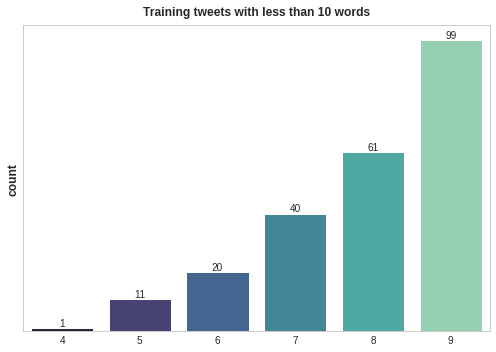

In [30]:

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [31]:
print(f" DF SHAPE: {df_train.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")


 DF SHAPE: (5975, 4)
 DF TEST SHAPE: (20632, 4)


In [32]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [33]:
df_train[1] = df_train[1].map({'negative':-1, 'neutral':0, 'positive':1})
df_test[1] = df_test[1].map({'negative':-1, 'neutral':0, 'positive':1})

In [34]:
df_train[1].value_counts()

 1    3078
 0    2036
-1     861
Name: 1, dtype: int64

In [35]:
df_train

,1,2,text_clean,text_len
0,-1,dear @Microsoft the newOoffice for Mac is grea...,dear the newooffice for mac is great and all b...,14
1,-1,@Microsoft how about you make a system that do...,how about you make a system that doesnt eat my...,27
2,-1,I may be ignorant on this issue but... should ...,i may be ignorant on this issue but should we ...,20
3,-1,"Thanks to @microsoft, I just may be switching ...",thanks to i just may be switching over to,9
4,0,If I make a game as a #windows10 Universal App...,if i make a game as a windows10 universal app ...,22
...,...,...,...,...
5970,1,@Racalto_SK ok good to know. Punting at MetLif...,ok good to know punting at metlife in december...,18
5971,0,everyone who sat around me at metlife was so a...,everyone who sat around me at metlife was so a...,20
5972,0,what giants or niners fans would wanna go to t...,what giants or niners fans would wanna go to t...,15
5973,1,Anybody want a ticket for tomorrow Colombia vs...,anybody want a ticket for tomorrow colombia vs...,11


In [36]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train[1]).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 1]);

In [37]:
train_os[1].value_counts()

-1    3078
 0    3078
 1    3078
Name: 1, dtype: int64

In [38]:
x_train = train_os['text_clean'].values
y_train = train_os[1].values
x_test = df_test['text_clean'].values
y_test = df_test[1].values
x_val = df_val['text_clean'].values
y_val = X_val[1].values

In [39]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [40]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [41]:
print(f"TRAINING DATA: {x_train.shape[0]}\nVALIDATION DATA: {x_val.shape[0]}\nTESTING DATA: {x_test.shape[0]}" )

TRAINING DATA: 9234
VALIDATION DATA: 2000
TESTING DATA: 20632


### Naive Bayes

In [42]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(x_train)
X_test_cv = clf.transform(x_test)

In [43]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [44]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train_tf, y_train_le)
nb_pred = nb_clf.predict(X_test_tf)

In [45]:
print('\tClassification Report for Naive Bayes:\n\n', classification_report(y_test_le, nb_pred, target_names=['negative', 'neutral', 'positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    negative       0.32      0.55      0.41      3231
     neutral       0.64      0.38      0.47     10342
    positive       0.53      0.67      0.59      7059

    accuracy                           0.50     20632
   macro avg       0.49      0.53      0.49     20632
weighted avg       0.55      0.50      0.50     20632



### BERT

In [46]:
MAX_LEN=128

In [47]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [48]:
train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [49]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [51]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [52]:
model.fit([train_input_ids, train_attention_masks], y_train, validation_data=([val_input_ids, val_attention_masks], y_val), epochs=2, batch_size=64)

Epoch 1/2
145/145 [==============================] - 243s 2s/step - loss: 0.9032 - categorical_accuracy: 0.5591 - val_loss: 0.9250 - val_categorical_accuracy: 0.5685
Epoch 2/2
145/145 [==============================] - 232s 2s/step - loss: 0.6005 - categorical_accuracy: 0.7358 - val_loss: 0.8980 - val_categorical_accuracy: 0.6230


In [53]:
result_bert = model.predict([test_input_ids,test_attention_masks])

645/645 [==============================] - 176s 269ms/step


In [54]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

<AxesSubplot:>

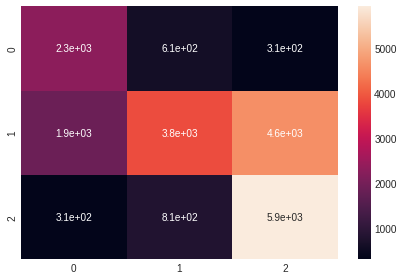

In [58]:
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))
sns.heatmap(cm, annot=True)


In [59]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.51      0.71      0.60      3231
     Neutral       0.73      0.37      0.49     10342
    Positive       0.55      0.84      0.66      7059

   micro avg       0.59      0.59      0.59     20632
   macro avg       0.60      0.64      0.58     20632
weighted avg       0.63      0.59      0.57     20632
 samples avg       0.59      0.59      0.59     20632



### RoBERTa

In [60]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [62]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [64]:
train_input_ids, train_attention_masks = tokenize_roberta(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(x_test, MAX_LEN)

In [65]:
def create_model(bert_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [66]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [67]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [68]:
model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=2, batch_size=64)

Epoch 1/2
145/145 [==============================] - 247s 2s/step - loss: 0.8413 - categorical_accuracy: 0.5936 - val_loss: 0.8667 - val_categorical_accuracy: 0.5790
Epoch 2/2
145/145 [==============================] - 232s 2s/step - loss: 0.5923 - categorical_accuracy: 0.7417 - val_loss: 0.8338 - val_categorical_accuracy: 0.6245


In [69]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


645/645 [==============================] - 169s 255ms/step


In [70]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

<AxesSubplot:>

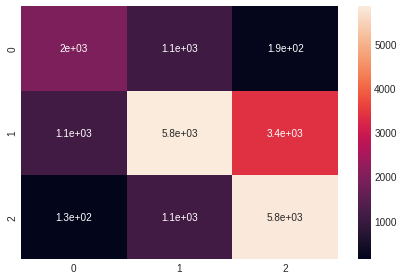

In [71]:
cm = confusion_matrix(y_test.argmax(1), y_pred_roberta.argmax(1))
sns.heatmap(cm, annot=True)

In [72]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.61      0.61      0.61      3231
     Neutral       0.73      0.57      0.64     10342
    Positive       0.62      0.82      0.71      7059

   micro avg       0.66      0.66      0.66     20632
   macro avg       0.65      0.66      0.65     20632
weighted avg       0.67      0.66      0.66     20632
 samples avg       0.66      0.66      0.66     20632

